In [1]:
import torch
import numpy as np
import os
os.chdir('..')

import torch_converter as tc
import instance_generator as ig
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from util import NumpyDataset, Dataset
from evaluate import evaluate_model, pp_output
from gnn_library.OBM_greedy import OBM_Greedy
#import evaluate as ev

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:2


In [3]:
GNN1, args1 = load('GNN1', device)
GNN2, args2 = load('GNN2', device)
GREEDY = OBM_Greedy()

### I. Meta GNN training/evaluation

In [57]:
args = {
    'processor':         'TEST',
    'head':              'meta',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        3,
    'dropout':           0.25,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 200; test_num = 50

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = Dataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2, GREEDY]
    )
)

test_data = Dataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GNN2, GREEDY]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [58]:
train_data.len()

489

In [60]:
args['epochs'] = 100
args['hidden_dim'] = 3
args['dropout'] = 0
args['lr'] = 0.01
_, _, META_GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/100 [00:00<?, ?Epochs/s]

1.0912242632945865


Training:   1%|          | 1/100 [00:01<01:41,  1.02s/Epochs]

TEST ACCURACY: 0.5454545021057129
TEST LOSS: 1.075744867324829


Training:   2%|▏         | 2/100 [00:01<01:17,  1.26Epochs/s]

1.0691607278792647
1.0525446106319778


Training:   3%|▎         | 3/100 [00:02<01:24,  1.15Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 1.052377700805664


Training:   4%|▍         | 4/100 [00:03<01:14,  1.29Epochs/s]

1.0357765841825364
1.019869389100065


Training:   5%|▌         | 5/100 [00:04<01:20,  1.18Epochs/s]

TEST ACCURACY: 0.5090909004211426
TEST LOSS: 1.0279183387756348


Training:   6%|▌         | 6/100 [00:04<01:12,  1.30Epochs/s]

1.0119452708094154
1.0108392618916517


Training:   7%|▋         | 7/100 [00:05<01:17,  1.19Epochs/s]

TEST ACCURACY: 0.5454545021057129
TEST LOSS: 0.9939550161361694


Training:   8%|▊         | 8/100 [00:06<01:10,  1.30Epochs/s]

0.9979506365360657
0.9964015798334696


Training:   9%|▉         | 9/100 [00:07<01:15,  1.20Epochs/s]

TEST ACCURACY: 0.5363636016845703
TEST LOSS: 0.9946773052215576


Training:  10%|█         | 10/100 [00:08<01:08,  1.32Epochs/s]

0.9895060325692768
0.9923412877845375


Training:  11%|█         | 11/100 [00:08<01:13,  1.22Epochs/s]

TEST ACCURACY: 0.5545454621315002
TEST LOSS: 0.9746605157852173


Training:  12%|█▏        | 12/100 [00:09<01:08,  1.29Epochs/s]

0.9907594334128444
0.9858327678619963


Training:  13%|█▎        | 13/100 [00:10<01:12,  1.20Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.9808701872825623


Training:  14%|█▍        | 14/100 [00:11<01:05,  1.30Epochs/s]

0.9859758186437845
0.9855127278524918


Training:  15%|█▌        | 15/100 [00:12<01:10,  1.21Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.9639987349510193


Training:  16%|█▌        | 16/100 [00:12<01:03,  1.31Epochs/s]

0.9795860097208393
0.9758031590097034


Training:  17%|█▋        | 17/100 [00:13<01:08,  1.21Epochs/s]

TEST ACCURACY: 0.29999998211860657
TEST LOSS: 1.160312533378601


Training:  18%|█▊        | 18/100 [00:14<01:02,  1.31Epochs/s]

0.9797921290426898
0.9807166273120966


Training:  19%|█▉        | 19/100 [00:15<01:06,  1.22Epochs/s]

TEST ACCURACY: 0.5636363625526428
TEST LOSS: 0.9678536057472229


Training:  20%|██        | 20/100 [00:15<01:00,  1.33Epochs/s]

0.9754889474568436
0.9752331133512875


Training:  21%|██        | 21/100 [00:16<01:03,  1.24Epochs/s]

TEST ACCURACY: 0.5909090638160706
TEST LOSS: 0.9600215554237366


Training:  22%|██▏       | 22/100 [00:17<00:58,  1.34Epochs/s]

0.9732581607403199
0.9710909629160641


Training:  23%|██▎       | 23/100 [00:18<01:02,  1.23Epochs/s]

TEST ACCURACY: 0.5363636016845703
TEST LOSS: 0.9733667969703674


Training:  24%|██▍       | 24/100 [00:19<00:57,  1.33Epochs/s]

0.9734779406178948
0.9703857993787052


Training:  25%|██▌       | 25/100 [00:19<01:00,  1.24Epochs/s]

TEST ACCURACY: 0.5636363625526428
TEST LOSS: 0.9742631912231445


Training:  26%|██▌       | 26/100 [00:20<00:55,  1.34Epochs/s]

0.9710936536574413
0.9699069964861333


Training:  27%|██▋       | 27/100 [00:21<00:59,  1.24Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.9565613269805908


Training:  28%|██▊       | 28/100 [00:22<00:53,  1.34Epochs/s]

0.9714299679290054
0.9682677915978773


Training:  29%|██▉       | 29/100 [00:23<00:58,  1.22Epochs/s]

TEST ACCURACY: 0.5363636016845703
TEST LOSS: 0.9801971912384033


Training:  30%|███       | 30/100 [00:23<00:53,  1.31Epochs/s]

0.9745631853008075
0.9654914062691125


Training:  31%|███       | 31/100 [00:24<00:56,  1.22Epochs/s]

TEST ACCURACY: 0.5090909004211426
TEST LOSS: 0.9926932454109192


Training:  32%|███▏      | 32/100 [00:25<00:53,  1.27Epochs/s]

0.9715208392933102
0.9702417882186016


Training:  33%|███▎      | 33/100 [00:26<00:56,  1.19Epochs/s]

TEST ACCURACY: 0.48181816935539246
TEST LOSS: 0.9985790252685547


Training:  34%|███▍      | 34/100 [00:27<00:51,  1.28Epochs/s]

0.9675486031729263
0.968539822930451


Training:  35%|███▌      | 35/100 [00:27<00:53,  1.21Epochs/s]

TEST ACCURACY: 0.5454545021057129
TEST LOSS: 0.9669309258460999


Training:  36%|███▌      | 36/100 [00:28<00:49,  1.31Epochs/s]

0.9701509481802553
0.9688228970900148


Training:  37%|███▋      | 37/100 [00:29<00:52,  1.21Epochs/s]

TEST ACCURACY: 0.581818163394928
TEST LOSS: 0.954772412776947


Training:  38%|███▊      | 38/100 [00:30<00:47,  1.30Epochs/s]

0.967294597430707
0.9688413737985497


Training:  39%|███▉      | 39/100 [00:31<00:50,  1.20Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.9514549374580383


Training:  40%|████      | 40/100 [00:31<00:45,  1.31Epochs/s]

0.9643982043051769
0.9688624047306661


Training:  41%|████      | 41/100 [00:32<00:49,  1.20Epochs/s]

TEST ACCURACY: 0.5636363625526428
TEST LOSS: 0.9521961808204651


Training:  42%|████▏     | 42/100 [00:33<00:44,  1.29Epochs/s]

0.9658830154892857
0.9633461885413266


Training:  43%|████▎     | 43/100 [00:34<00:47,  1.21Epochs/s]

TEST ACCURACY: 0.5909090638160706
TEST LOSS: 0.9413917064666748


Training:  44%|████▍     | 44/100 [00:34<00:42,  1.31Epochs/s]

0.9639660652673562
0.9685104539301742


Training:  45%|████▌     | 45/100 [00:35<00:45,  1.22Epochs/s]

TEST ACCURACY: 0.48181816935539246
TEST LOSS: 0.9999633431434631


Training:  46%|████▌     | 46/100 [00:36<00:41,  1.31Epochs/s]

0.9668076293112554
0.9639110050805995


Training:  47%|████▋     | 47/100 [00:37<00:43,  1.22Epochs/s]

TEST ACCURACY: 0.5909090638160706
TEST LOSS: 0.9530892968177795


Training:  48%|████▊     | 48/100 [00:38<00:39,  1.31Epochs/s]

0.9673702967922624
0.9651511629666287


Training:  49%|████▉     | 49/100 [00:39<00:41,  1.22Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.9630119204521179


Training:  50%|█████     | 50/100 [00:39<00:37,  1.33Epochs/s]

0.9667863286346015
0.9683462503253805


Training:  51%|█████     | 51/100 [00:40<00:39,  1.23Epochs/s]

TEST ACCURACY: 0.4272727072238922
TEST LOSS: 1.0427056550979614


Training:  52%|█████▏    | 52/100 [00:41<00:36,  1.32Epochs/s]

0.9682613614878041
0.9648139961901862


Training:  53%|█████▎    | 53/100 [00:42<00:38,  1.21Epochs/s]

TEST ACCURACY: 0.581818163394928
TEST LOSS: 0.943176805973053


Training:  54%|█████▍    | 54/100 [00:42<00:35,  1.30Epochs/s]

0.963450022392234
0.9665254281342395


Training:  55%|█████▌    | 55/100 [00:43<00:37,  1.21Epochs/s]

TEST ACCURACY: 0.5909090638160706
TEST LOSS: 0.9430882930755615


Training:  56%|█████▌    | 56/100 [00:44<00:33,  1.30Epochs/s]

0.9676263711447608
0.968846221155428


Training:  57%|█████▋    | 57/100 [00:45<00:35,  1.22Epochs/s]

TEST ACCURACY: 0.581818163394928
TEST LOSS: 0.9629247188568115


Training:  58%|█████▊    | 58/100 [00:46<00:31,  1.33Epochs/s]

0.9639384494237373
0.9610845747657105


Training:  59%|█████▉    | 59/100 [00:46<00:33,  1.23Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.9479584097862244


Training:  60%|██████    | 60/100 [00:47<00:30,  1.32Epochs/s]

0.9681319651671958
0.9660045087703166


Training:  61%|██████    | 61/100 [00:48<00:32,  1.22Epochs/s]

TEST ACCURACY: 0.5999999642372131
TEST LOSS: 0.9456768035888672


Training:  62%|██████▏   | 62/100 [00:49<00:29,  1.31Epochs/s]

0.9643814946488612
0.9653311767948674


Training:  63%|██████▎   | 63/100 [00:50<00:30,  1.20Epochs/s]

TEST ACCURACY: 0.5909090638160706
TEST LOSS: 0.9422322511672974


Training:  64%|██████▍   | 64/100 [00:50<00:27,  1.31Epochs/s]

0.9729079769920473
0.9693884035317201


Training:  65%|██████▌   | 65/100 [00:51<00:28,  1.21Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.959419846534729


Training:  66%|██████▌   | 66/100 [00:52<00:26,  1.31Epochs/s]

0.969636387010781
0.9657686077256388


Training:  67%|██████▋   | 67/100 [00:53<00:27,  1.21Epochs/s]

TEST ACCURACY: 0.45454543828964233
TEST LOSS: 1.0111926794052124


Training:  68%|██████▊   | 68/100 [00:53<00:24,  1.31Epochs/s]

0.9658462445428766
0.9679114732030467


Training:  69%|██████▉   | 69/100 [00:54<00:25,  1.20Epochs/s]

TEST ACCURACY: 0.581818163394928
TEST LOSS: 0.9453949928283691


Training:  70%|███████   | 70/100 [00:55<00:22,  1.31Epochs/s]

0.9676709394513464
0.9617713816570602


Training:  71%|███████   | 71/100 [00:56<00:23,  1.23Epochs/s]

TEST ACCURACY: 0.581818163394928
TEST LOSS: 0.9423354864120483


Training:  72%|███████▏  | 72/100 [00:57<00:21,  1.32Epochs/s]

0.9630381506401093
0.9625505555139241


Training:  73%|███████▎  | 73/100 [00:58<00:22,  1.21Epochs/s]

TEST ACCURACY: 0.4999999701976776
TEST LOSS: 0.9919069409370422


Training:  74%|███████▍  | 74/100 [00:58<00:19,  1.31Epochs/s]

0.9666713142199994
0.9645233562631353


Exception ignored in: <function _releaseLock at 0x7f366100a440>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Training:  75%|███████▌  | 75/100 [00:59<00:21,  1.19Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.944675624370575


Training:  76%|███████▌  | 76/100 [01:00<00:18,  1.28Epochs/s]

0.9638097756723197
0.9620442890194539


Training:  77%|███████▋  | 77/100 [01:01<00:19,  1.19Epochs/s]

TEST ACCURACY: 0.5909090638160706
TEST LOSS: 0.9396831393241882


Training:  78%|███████▊  | 78/100 [01:02<00:16,  1.30Epochs/s]

0.9623425729679428
0.9597593414271536


Training:  79%|███████▉  | 79/100 [01:02<00:17,  1.20Epochs/s]

TEST ACCURACY: 0.581818163394928
TEST LOSS: 0.9457892179489136


Training:  80%|████████  | 80/100 [01:03<00:15,  1.30Epochs/s]

0.9627086666464074
0.9653834520185895


Training:  81%|████████  | 81/100 [01:04<00:15,  1.20Epochs/s]

TEST ACCURACY: 0.5909090638160706
TEST LOSS: 0.9470983743667603


Training:  82%|████████▏ | 82/100 [01:05<00:13,  1.30Epochs/s]

0.9609664642006341
0.9639237507233103


Training:  83%|████████▎ | 83/100 [01:06<00:14,  1.21Epochs/s]

TEST ACCURACY: 0.5727272629737854
TEST LOSS: 0.9429917931556702


Training:  84%|████████▍ | 84/100 [01:06<00:12,  1.30Epochs/s]

0.9651354184423732
0.9768511890633705


Training:  85%|████████▌ | 85/100 [01:07<00:12,  1.21Epochs/s]

TEST ACCURACY: 0.5363636016845703
TEST LOSS: 0.9725831151008606


Training:  86%|████████▌ | 86/100 [01:08<00:10,  1.29Epochs/s]

0.961258620937909
0.9616808406170648


Training:  87%|████████▋ | 87/100 [01:09<00:10,  1.20Epochs/s]

TEST ACCURACY: 0.5545454621315002
TEST LOSS: 0.9673595428466797


Training:  88%|████████▊ | 88/100 [01:10<00:09,  1.29Epochs/s]

0.9637789469067548
0.960186353002833


Training:  89%|████████▉ | 89/100 [01:10<00:09,  1.20Epochs/s]

TEST ACCURACY: 0.49090906977653503
TEST LOSS: 1.0001541376113892


Training:  90%|█████████ | 90/100 [01:11<00:07,  1.31Epochs/s]

0.9577311928286875
0.9648407345412943


Training:  91%|█████████ | 91/100 [01:12<00:07,  1.21Epochs/s]

TEST ACCURACY: 0.4999999701976776
TEST LOSS: 1.0054303407669067


Training:  92%|█████████▏| 92/100 [01:13<00:06,  1.31Epochs/s]

0.9704226435815386


Training:  92%|█████████▏| 92/100 [01:13<00:06,  1.25Epochs/s]


KeyboardInterrupt: 

In [48]:
seed = np.random.randint(0, 500000)
(m, n) = (20, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 100, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = evaluate_model(
    meta_model=META_GNN,
    meta_model_type='gnn',
    base_models=[GNN1, GNN2, GREEDY],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN1],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios, _, show_log=False)

-- Competitive ratios --
GNN: 0.9559
Greedy: 0.9446


-- Competitive ratios --
GNN: 0.9551
Greedy: 0.9446


-- Competitive ratios --
GNN: 0.9637
Greedy: 0.9446


### II. Meta NN training

In [240]:
train_num = 200; test_num = 40

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        5,
    'input_dim':         17,
    'batch_size':        4,
    'hidden_dim':        16,
    'output_dim':        2,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}


rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = NumpyDataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='nn',
        base_models=[GNN1, GNN2, GREEDY]
    )
)

test_data = NumpyDataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='nn',
        base_models=[GNN1, GNN2, GREEDY]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [55]:
ex = test_data[0]
example = (ex[0].to('cuda:2'), ex[1].to('cuda:2')) 

In [72]:
train_data[6]

(tensor([0.5556, 0.4504, 1.0000, 0.8687, 0.7812, 0.5519, 0.2932, 1.0000, 0.0455,
         0.4227, 0.6667, 0.8468, 0.9639, 1.0000, 1.0000, 0.7676, 1.0000, 0.5995,
         1.0000, 0.3169, 0.8512, 0.0000, 0.4511]),
 tensor([0., 1.]))

In [2]:
args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        2,
    'input_dim':         23,
    'batch_size':        20,
    'hidden_dim':        18,
    'output_dim':        3,
    'dropout':           0,
    'epochs':            100,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

_, _, META_NN, _ = train(train_loader, test_loader, args)

NameError: name 'device' is not defined

In [245]:
seed = np.random.randint(0, 50000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = evaluate_model(
    meta_model=META_NN,
    meta_model_type='nn',
    base_models=[GNN1, GNN2, GREEDY],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN1],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN2],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)

-- Competitive ratios --
GNN: 0.9806
Greedy: 0.988


-- Competitive ratios --
GNN: 0.9436
Greedy: 0.988


-- Competitive ratios --
GNN: 0.9685
Greedy: 0.988


In [209]:
torch.tensor([1,2]) + 3

tensor([4, 5])

In [49]:
num_trials = 10
node_configs = [(x, 16) for x in np.arange(4, 64, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'threshold': 0.2,
        'scaling': 1 / np.sqrt(2),
    }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)
data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)

        rng = np.random.default_rng(seed)
        (meta_learned_ratios, _) = evaluate_model(
            meta_model=META_GNN,
            meta_model_type='gnn',
            base_models=[GNN1, GNN2, GREEDY],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn1_learned_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN1],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn2_learned_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        data[graph_config['graph_type']].append(np.array(
            [
                meta_learned_ratios,
                gnn1_learned_ratios,
                gnn2_learned_ratios,
                greedy_ratios
            ]
        ))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75]
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (4, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (8, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (12, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (16, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (20, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (24, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (28, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (32, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (36, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (40, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (44, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (48, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (52, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (56, 16)
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (60, 16)
{'graph_type': 'BA', 'ba_param': 

ER


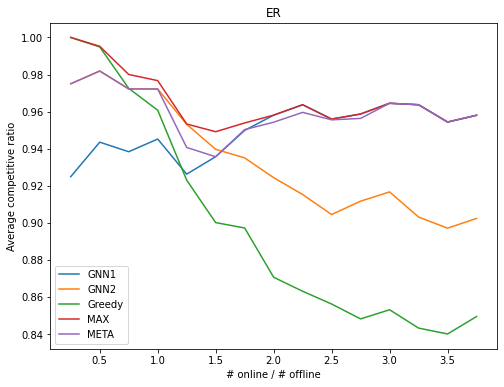

BA


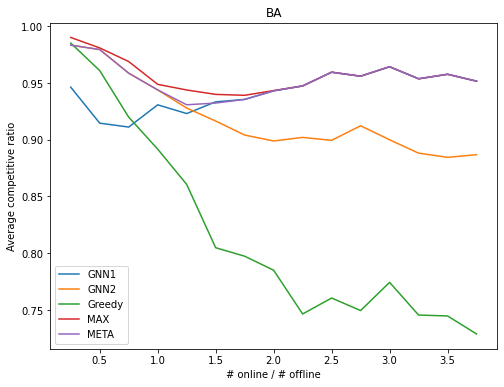

GEOM


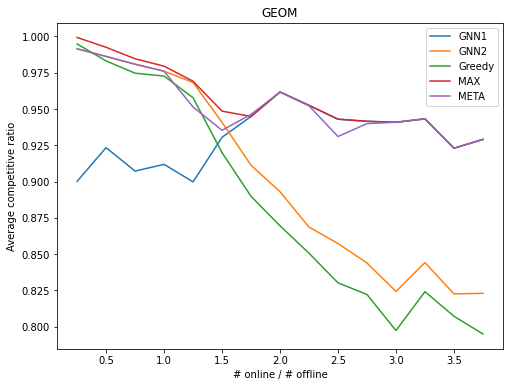

In [50]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for graph_type, comp_ratios in data.items():
    greedy_avg_ratios = []
    meta_avg_ratios = []
    gnn1_avg_ratios = []
    gnn2_avg_ratios = []
    max_avg_ratios = []

    for trial_ratios in comp_ratios:
        meta_avg_ratios.append(np.array(trial_ratios[0]).mean())
        gnn1_avg_ratios.append(np.array(trial_ratios[1]).mean())
        gnn2_avg_ratios.append(np.array(trial_ratios[2]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[3]).mean())
        max_avg_ratios.append(np.array(np.max(trial_ratios[1:, :], axis=0)).mean())

    print(graph_type)
    fig = plt.figure(figsize=(8,6))
    plt.title(graph_type)
    plt.plot(ratios, gnn1_avg_ratios, label='GNN1')
    plt.plot(ratios, gnn2_avg_ratios, label='GNN2')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, max_avg_ratios, label='MAX')
    plt.plot(ratios, meta_avg_ratios, label='META')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.show()


In [ ]:
comp = np.vstack([gnn1_learned_ratios, gnn2_learned_ratios, greedy_ratios]).T
comp[:10]

In [ ]:
print(np.max(comp[:2, :], axis=1).mean())
print(comp.mean(axis=0))

In [ ]:
index1 = np.argmax(comp[:, 0] - comp[:, 1])
index2 = np.argmax(comp[:, 1] - comp[:, 0])

In [ ]:
tc._featurize(instances[index1])

In [ ]:
tc._featurize(instances[index2])

In [ ]:
GNN2_features = []
GNN1_features = []
for i, boolean in enumerate(comp[:, 1] > comp[:, 0]):
    if boolean:
        GNN2_features.append(tc._featurize(instances[i]))
    else:
        GNN1_features.append(tc._featurize(instances[i]))

out1 = np.vstack(GNN1_features)
out2 = np.vstack(GNN2_features)


In [ ]:
out1.mean(axis=0)

In [ ]:
out2.mean(axis=0)